# EDA on Project Development Cycle

* Over-sampling of released projects?
  * released percentage in ghtorrent data v.s. released in current data
* Number of commits by project age?

In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(cluster.scheduler)
print(client)

<Scheduler: "tcp://127.0.0.1:35241" processes: 4 cores: 16>
<Client: 'tcp://127.0.0.1:35241' processes=4 threads=16, memory=16.80 GB>


In [2]:
import collections
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask import compute as dcompute
import os
data_dir = '/home/faithfeng/Dropbox/GitHub/Data/new_python_dataset'

In [3]:
pyprojects = dd.read_csv(data_dir+os.sep+'merged_pyprojects.csv')

print(len(pyprojects))
pyprojects.head()

369343


,project_id,description,url,released,from_pypi
0,67,Chinese segmentation library,https://api.github.com/repos/victorlin/loso,0.0,0.0
1,119,Easy to use CLI for picture classification bas...,https://api.github.com/repos/fudgefr/pyctozor,0.0,0.0
2,197,Use the Twilio API to send hourly catfacts!,https://api.github.com/repos/rossdylan/catfacts,0.0,0.0
3,220,GoodData client library written in python.,https://api.github.com/repos/comoga/gooddata-p...,0.0,0.0
4,265,"A django rest framework for handling requests,...",https://api.github.com/repos/cakey/Shimmer,0.0,0.0


In [4]:
# percentage of release from GHTorrent
ghrelease = pyprojects[pyprojects['from_pypi']==0]['released'].mean()
allrelease = pyprojects['released'].mean()
print(dcompute(ghrelease, allrelease))

(0.0703590349091926, 0.18993726698488939)


__It is clear that we have an over-sampling of released projects.__
* If we don't use PyPI data, the release percentage is about 7\%.
* After merging with PyPI data, the release percentage becomes 18.99\%.

In [5]:
releases = dd.read_csv(data_dir+os.sep+'pypi_dependencies.csv')
releases.head()

,name,version,date,deps,raw_dependencies,url,project_id
0,0,0.0.0,8/6/17,NaN,{},NaN,NaN
1,0-core-client,1.1.0a3,6/9/17,NaN,{},github.com/zero-os/0-core,65822010.0
2,0-core-client,1.1.0a4,6/21/17,NaN,{},github.com/zero-os/0-core,65822010.0
3,0-core-client,1.1.0a5,7/17/17,NaN,{},github.com/zero-os/0-core,65822010.0
4,0-core-client,1.1.0a7,8/8/17,NaN,{},github.com/zero-os/0-core,65822010.0


In [6]:
releases = releases.dropna(subset=['project_id', 'date'])
print(len(releases))

541592


In [7]:
dateParser = lambda x: pd.to_datetime(x, format='%m/%d/%y')
meta = ('time', 'datetime64[ns]')
releases['datetime'] = releases['date'].map_partitions(pd.to_datetime, meta=meta)
releases.head()

,name,version,date,deps,raw_dependencies,url,project_id,datetime
1,0-core-client,1.1.0a3,6/9/17,NaN,{},github.com/zero-os/0-core,65822010.0,2017-06-09
2,0-core-client,1.1.0a4,6/21/17,NaN,{},github.com/zero-os/0-core,65822010.0,2017-06-21
3,0-core-client,1.1.0a5,7/17/17,NaN,{},github.com/zero-os/0-core,65822010.0,2017-07-17
4,0-core-client,1.1.0a7,8/8/17,NaN,{},github.com/zero-os/0-core,65822010.0,2017-08-08
5,0-core-client,1.1.0a8,10/11/17,NaN,{},github.com/zero-os/0-core,65822010.0,2017-10-11


In [8]:
num_releases = releases.groupby('project_id')['version'].count().compute()
num_releases.head()

project_id
64.0     16
253.0    41
268.0     2
436.0     3
514.0     4
Name: version, dtype: int64

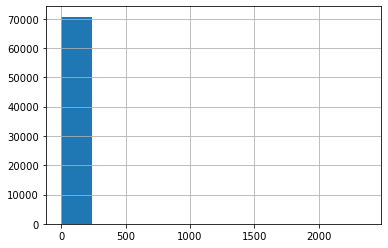

In [10]:
num_releases.hist()

In [ ]:
num_releases = pd.DataFrame(num_releases).reset_index()
num_releases.head()

In [23]:
first_three = releases.groupby('project_id')['datetime'].apply(lambda x: x.nsmallest(3), meta=('datetime', 'datetime64[ns]')).compute()

In [29]:
(first_three.reset_index().groupby('project_id'))['datetime'].diff(1)//np.timedelta64(1, 'M')

0          NaN
1          NaN
2          NaN
3         11.0
4         30.0
          ... 
169975     NaN
169976     0.0
169977     0.0
169978     NaN
169979     NaN
Name: datetime, Length: 169980, dtype: float64